In [2]:
import csv
import os
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
sys.path.append('../Lib/PythonML')

from linear import Linear
from multicouche import MLP
from svm import SVM 
from random import randrange
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D

In [3]:
labels = ['guitare','saxo', 'piano']
dll_path = '../Lib/SupervisingML/target/debug/libmllib_rust.so'
train_path = '../Dataset/Train/Fourier'
validation_path = '../Dataset/Test/Fourier'

# Fourier

In [4]:
frequency_max = 8000
frequency_precision = 2

In [5]:
def getCsvData(path):
    with open(path, newline='\n') as f:
        reader = csv.reader(f, delimiter=';')
        next(reader, None)
        data = [] 
        count = 0
        #0,1 -> 0 2,3 -> 1 4,5 -> 2
        for row in reader:
            if len(data) == (frequency_max * 2) / frequency_precision:
                break
            if count % frequency_precision != 0:
                count += 1
                continue
    
            frequency = float(row[0])
            if frequency > frequency_max:
                break
            if int(frequency) * 2 + 1 < count:
                continue
            count += 1
            data.append([float(row[0]), float(row[1])])
        return data

def importData(path, label_number = len(labels), max_by_label = -1):
    data = []
    label = []
    if label_number > len(labels):
        label_number = len(labels)
    for i in range(label_number):
        data_count_by_label = 0
        directory_path = os.path.join(path, labels[i])
        for r, _, f in os.walk(directory_path):
            for file in f:
                if data_count_by_label == max_by_label and max_by_label != -1:
                    break
                
                data_buff = getCsvData(os.path.join(directory_path, file))
                if len(data_buff) == (frequency_max * 2) / frequency_precision:
                    data.append(data_buff)
                    if i == 0 and label_number == 2:
                        label.append(-1)
                    else:
                        label.append(i)
                    data_count_by_label += 1

    return (np.array(data, dtype='float64'), np.array(label, dtype='float64'))

def shuffle(data,label):
    for i in range(len(label)):
        rand = random.randrange(i,len(label))
        label[i], label[rand] = label[rand], label[i]
        data[i], data[rand] = data[rand], data[i]
    return (data,label)

def max_indice(values):
    max_value = values[0]
    max_ind = 0
    for i in range(1, len(values)):
        if values[i] > max_value:
            max_ind = i
            max_value = values[i]
    return max_ind

def test_linear(data, label):
    good_predict = [0,0]
    number_of_predict = [0,0]
    for i in range(len(data)):
        predicted_value = linear.predict_linear_model_classification(data[i])
        if label[i] == -1.0:
            number_of_predict[0] += 1
            if predicted_value == -1.0:
                good_predict[0] += 1
        else:
            number_of_predict[1] += 1
            if predicted_value == 1.0:
                good_predict[1] += 1
    return (good_predict, number_of_predict)

def test_mlp(model, data, label, last_couche):
    good_predict = [0 for i in range(last_couche + 1)]
    number_of_predict = [0 for i in range(last_couche + 1)]
    for i in range(len(data)):
        predicted_value = model.predict_multicouche_model_classification(data[i])
        if last_couche == 1:
            predicted_value = predicted_value[0]
            if label[i] < 0.0:
                number_of_predict[0] += 1
                if predicted_value < 0.0:
                    good_predict[0] += 1
            else:
                number_of_predict[1] += 1
                if predicted_value >= 0.0:
                    good_predict[1] += 1
        else:
            predicted_list = [predicted_value[i] for i in range(last_couche)]
            max_ind = max_indice(predicted_list)  
            number_of_predict[int(label[i]) + 1] += 1
            if int(label[i]) == max_ind:
                good_predict[int(label[i]) +  1] += 1
    return (good_predict, number_of_predict)

## 2 Classes

## Linear

In [6]:
number_of_label = 2
train_max_by_label = 800 # 1900 max
val_max_by_label = 340 # 340 max

train_data, train_label = importData(train_path, number_of_label, train_max_by_label)
validation_data, validation_label = importData(validation_path, number_of_label, val_max_by_label)

print("Import Finish")
print(train_data.shape)
print(validation_data.shape)

train_data, train_label = shuffle(train_data, train_label)
validation_data, validation_label = shuffle(validation_data, validation_label)  

Import Finish
(1600, 8000, 2)
(674, 8000, 2)


### Keras

On peut voir ici que le modele linéaire n'essaye pas de séparer les deux classes mais prédit toujours la même classe

Epoch 1/10
50/50 [==============================] - 0s 4ms/step - loss: 2.5000 - accuracy: 0.5000 - val_loss: 2.5000 - val_accuracy: 0.5000
Epoch 2/10
50/50 [==============================] - 0s 3ms/step - loss: 2.5000 - accuracy: 0.5000 - val_loss: 2.5000 - val_accuracy: 0.5000
Epoch 3/10
50/50 [==============================] - 0s 3ms/step - loss: 2.5000 - accuracy: 0.5000 - val_loss: 2.5000 - val_accuracy: 0.5000
Epoch 4/10
50/50 [==============================] - 0s 4ms/step - loss: 2.5000 - accuracy: 0.5000 - val_loss: 2.5000 - val_accuracy: 0.5000
Epoch 5/10
50/50 [==============================] - 0s 5ms/step - loss: 2.5000 - accuracy: 0.5000 - val_loss: 2.5000 - val_accuracy: 0.5000
Epoch 6/10
50/50 [==============================] - 0s 6ms/step - loss: 2.5000 - accuracy: 0.5000 - val_loss: 2.5000 - val_accuracy: 0.5000
Epoch 7/10
50/50 [==============================] - 0s 4ms/step - loss: 2.5000 - accuracy: 0.5000 - val_loss: 2.5000 - val_accuracy: 0.5000
Epoch 8/10
50/50 [==

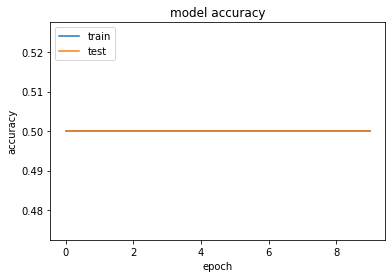

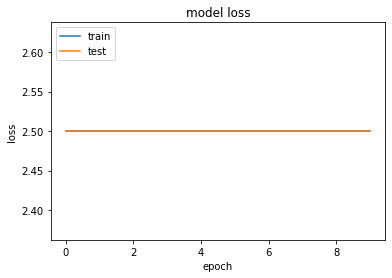

In [18]:
train_label_cat = to_categorical(train_label, 2)
validation_label_cat = to_categorical(validation_label, 2)

model = Sequential()
model.add(keras.layers.Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(1, activation='tanh'))

model.compile(optimizer = 'adam',  loss="mean_squared_error",  metrics=['accuracy'])
history = model.fit(train_data, train_label_cat, 
                    validation_data=(validation_data, validation_label_cat), epochs= 10)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Lib Rust

2 types de résultats :
Predict validation -> -1.0 : 48 of 150 / 1.0 : 130 of 150
Predict train -> -1.0 : 265 of 800 / 1.0 : 715 of 800
ou
Predict validation -> -1.0 : 150 of 150 / 1.0 : 0 of 150
Predict train -> -1.0 : 800 of 800 / 1.0 : 0 of 800

In [29]:
linear = Linear(dll_path)
linear.init_linear_model(((frequency_max * 2) // frequency_precision) * 2)
linear.train_linear_model_classification(train_data.flatten(), train_label.flatten(), len(train_label), 20000, 0.3)

good_predict, number_of_predict = test_linear(validation_data, validation_label)
#print("predicted result : " + str(predicted_value) + " / result : " + str(validation_label[i]))
print("Test :")
print("Predict of -1.0 : " + str(good_predict[0]) + " of " + str(number_of_predict[0]))
print("Predict of 1.0 : " + str(good_predict[1]) + " of " + str(number_of_predict[1]))

good_predict, number_of_predict = test_linear(train_data, train_label)
print("Train :")
print("Predict of -1.0 : " + str(good_predict[0]) + " of " + str(number_of_predict[0]))
print("Predict of 1.0 : " + str(good_predict[1]) + " of " + str(number_of_predict[1]))

Test :
Predict of -1.0 : 37 of 200
Predict of 1.0 : 194 of 200
Train :
Predict of -1.0 : 151 of 800
Predict of 1.0 : 791 of 800


## MLP

### Keras

Epoch 1/10
50/50 [==============================] - 1s 25ms/step - loss: 0.5355 - accuracy: 0.5000 - val_loss: 0.4998 - val_accuracy: 0.5000
Epoch 2/10
50/50 [==============================] - 1s 29ms/step - loss: 0.4998 - accuracy: 0.5000 - val_loss: 0.4997 - val_accuracy: 0.5000
Epoch 3/10
50/50 [==============================] - 1s 21ms/step - loss: 0.4997 - accuracy: 0.5000 - val_loss: 0.4996 - val_accuracy: 0.5000
Epoch 4/10
50/50 [==============================] - 1s 24ms/step - loss: 0.4992 - accuracy: 0.5000 - val_loss: 0.4984 - val_accuracy: 0.5000
Epoch 5/10
50/50 [==============================] - 1s 24ms/step - loss: 0.4136 - accuracy: 0.5000 - val_loss: 0.2614 - val_accuracy: 0.5000
Epoch 6/10
50/50 [==============================] - 1s 25ms/step - loss: 0.2525 - accuracy: 0.5000 - val_loss: 0.2501 - val_accuracy: 0.5000
Epoch 7/10
50/50 [==============================] - 1s 20ms/step - loss: 0.2500 - accuracy: 0.5000 - val_loss: 0.2500 - val_accuracy: 0.5000
Epoch 8/10
50

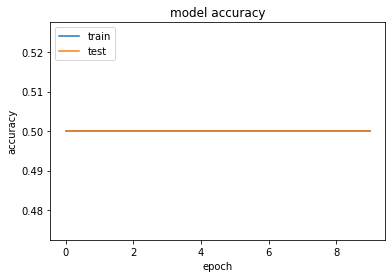

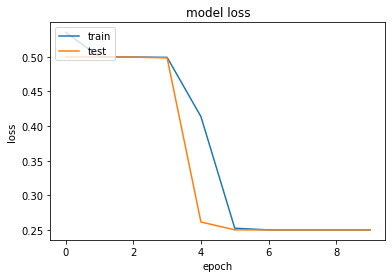

[0.5000001] / 1.0
[0.5000001] / 1.0
[0.5000001] / -1.0
[0.5000001] / -1.0
[0.5000001] / 1.0
[0.5000001] / 1.0
[0.5000001] / 1.0
[0.5000001] / 1.0
[0.5000001] / 1.0
[0.5000001] / 1.0
[0.5000001] / 1.0
[0.5000001] / -1.0
[0.5000001] / -1.0
[0.5000001] / 1.0
[0.5000001] / -1.0
[0.5000001] / 1.0
[0.5000001] / -1.0
[0.5000001] / 1.0
[0.5000001] / 1.0
[0.5000001] / 1.0
[0.5000001] / 1.0
[0.5000001] / 1.0
[0.5000001] / -1.0
[0.5000001] / 1.0
[0.5000001] / 1.0
[0.5000001] / -1.0
[0.5000001] / -1.0
[0.5000001] / 1.0
[0.5000001] / 1.0
[0.5000001] / 1.0
[0.5] / 1.0
[0.5] / 1.0
[0.5000001] / 1.0
[0.5000001] / -1.0
[0.5000001] / 1.0
[0.5000001] / -1.0
[0.5000001] / 1.0
[0.5000001] / -1.0
[0.5000001] / -1.0
[0.5000001] / 1.0
[0.5000001] / -1.0
[0.5000001] / -1.0
[0.5000001] / 1.0
[0.5000001] / -1.0
[0.5000001] / 1.0
[0.5000001] / 1.0
[0.5000001] / 1.0
[0.5000001] / 1.0
[0.5000001] / -1.0
[0.5000001] / -1.0
[0.5000001] / -1.0
[0.5000001] / 1.0
[0.5000001] / 1.0
[0.5000001] / -1.0
[0.5000001] / -1.0
[

In [36]:
train_label_cat = to_categorical(train_label, 2)
validation_label_cat = to_categorical(validation_label, 2)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=train_data.shape[1:]),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(1, activation='tanh')
])
prin
model.compile(optimizer = 'adam',  loss='mean_squared_error',  metrics=['accuracy'])
history = model.fit(train_data, train_label_cat, 
                    validation_data=(validation_data, validation_label_cat), epochs= 40)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


prediction = model.predict(validation_data)
for i in range(len(prediction)):
    print(str(prediction[i]) + " / " + str(validation_label[i]))

### Lib Rust

predict -1 -> 340 sur 340
predict 1 -> 0 sur 334

In [20]:
last_couche = 2

mlp = MLP(dll_path)
mlp.init_multicouche_model(np.array([train_data.shape[1] * train_data.shape[2], 64, 64, last_couche], dtype='float64'))
mlp.train_multicouche_model_classification(train_data.flatten(), train_label.flatten(), train_data.shape[0], 100.0, 0.2)

good_predict, number_of_predict = test_mlp(mlp, validation_data, validation_label, last_couche)
print("Test :")
print(good_predict)
print(number_of_predict)

Test :
[0, 0, 0]
[340, 0, 334]


## 3 Classes

## MLP

In [6]:
number_of_label = 3
train_max_by_label = 600
val_max_by_label = 100
train_data, train_label = importData(train_path, number_of_label, train_max_by_label)
validation_data, validation_label = importData(validation_path, number_of_label, val_max_by_label)

print("Import Finish")
print(train_data.shape)
print(train_label.shape)

train_data, train_label = shuffle(train_data, train_label)
validation_data, validation_label = shuffle(validation_data, validation_label)  

Import Finish
(1800, 8000, 2)
(1800,)


### Keras

Bloque a 33%

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               2048128   
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 387       
Total params: 2,065,027
Trainable params: 2,065,027
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
57/57 [==============================] - 2s 26ms/step - loss: 1.1519 - accuracy: 0.3378 - val_loss: 1.1115 - val_accuracy: 0.3333
Epoch 2/10
57/57 [==============================] - 1s 13ms/step - loss: 1.1112 - accuracy: 0.3244 - 

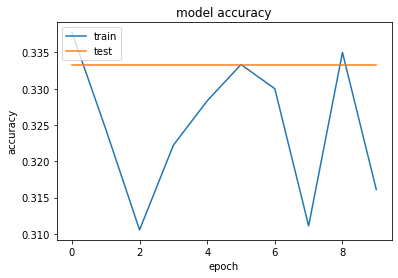

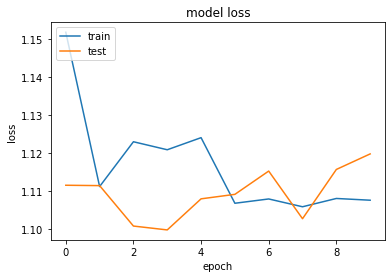

In [11]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=train_data.shape[1:]),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(3)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()
history = model.fit(train_data, train_label, validation_data=(validation_data, validation_label), epochs=10)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Lib Rust

Prédit toujours la même classe comme avec Keras

In [27]:
last_couche = 3

mlp = MLP(dll_path)
mlp.init_multicouche_model(np.array([train_data.shape[1] * train_data.shape[2], 128, 128, last_couche], dtype='float64'))
mlp.train_multicouche_model_classification(train_data.flatten(), train_label.flatten(), train_data.shape[0], 1000.0, 0.03)

good_predict, number_of_predict = test_mlp(mlp, validation_data, validation_label, last_couche)
print("Test :")
print(good_predict)
print(number_of_predict)

Test :
[0, 0, 12, 0]
[0, 12, 12, 14]


# Spectrogram

In [12]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import sys

sys.path.append('../Lib/PythonML')
from linear import Linear
from multicouche import MLP
from tensorflow import keras
from random import randrange

In [15]:
dll_path = '../Lib/SupervisingML/target/debug/libmllib_rust.so'
ORIGINAL_IMG_HEIGHT = 109
ORIGINAL_IMG_WIDTH = 146
train_path = '../Dataset/Train/Spectrogram'
validation_path = '../Dataset/Test/Spectrogram'

In [16]:
def shuffle(data,label):
    for i in range(len(label)):
        rand = random.randrange(i,len(label))
        label[i], label[rand] = label[rand], label[i]
        data[i], data[rand] = data[rand], data[i]
    return (data,label)

def test(model, data, label, last_couche):
    good_predict = [0 for i in range(last_couche + 1)]
    number_of_predict = [0 for i in range(last_couche + 1)]
    for i in range(len(data)):
        predicted_value = model.predict_multicouche_model_classification(data[i])
        if last_couche == 1:
            predicted_value = predicted_value[0]
            if label[i] == 0.0:
                number_of_predict[0] += 1
                if predicted_value < 0.0:
                    good_predict[0] += 1
            else:
                number_of_predict[1] += 1
                if predicted_value >= 0.0:
                    good_predict[1] += 1
        else:
            predicted_list = [predicted_value[i] for i in range(last_couche)]
            max_ind = max_indice(predicted_list)  
            number_of_predict[int(label[i]) + 1] += 1
            if int(label[i]) == max_ind:
                good_predict[int(label[i]) +  1] += 1
    return (good_predict, number_of_predict)

def max_indice(values):
    max_value = values[0]
    max_ind = 0
    for i in range(1, len(values)):
        if values[i] > max_value:
            max_ind = i
            max_value = values[i]
    return max_ind

## 2 Classes

In [17]:
class_names = ['piano', 'saxo'] # 'guitare'
max_data_by_label = 1500
max_val_by_label = 320
IMG_HEIGHT = 32
IMG_WIDTH = 32
target_size = (IMG_WIDTH, IMG_HEIGHT)

In [18]:
train_images = []
validation_images = []
train_labels = []
validation_labels = []

for i in range(len(class_names)):
    for r, _, f in os.walk(os.path.join(train_path, class_names[i])):
        for file in f:
            if len(train_images) == max_data_by_label * (i + 1):
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    train_images.append(mpimg.imread(os.path.join(r, file))) 
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    train_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                train_labels.append(i)

    for r, _, f in os.walk(os.path.join(validation_path, class_names[i])):
        for file in f:
            if len(validation_images) == max_val_by_label * (i + 1):
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    validation_images.append(mpimg.imread(os.path.join(r, file)))
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    validation_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                validation_labels.append(i)
                    
train_images = np.array(train_images, dtype='float64')
train_labels = np.array(train_labels, dtype='float64')
validation_images = np.array(validation_images, dtype='float64')
validation_labels = np.array(validation_labels, dtype='float64')

train_images, train_labels = shuffle(train_images, train_labels)
validation_images, validation_labels = shuffle(validation_images, validation_labels)

if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
    train_images = np.delete(train_images, 3, 3)
    validation_images = np.delete(validation_images, 3, 3)
print("End of Import")
print(train_images.shape)
print(train_labels.shape)

End of Import
(3000, 32, 32, 3)
(3000,)


### MLP

### Keras

Epoch 97/100
loss: 0.5981 - accuracy: 0.6867 - val_loss: 0.6500 - val_accuracy: 0.6359

In [21]:
'''
model = keras.models.Sequential([
    keras.layers.Conv2D(8, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(16, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    #over-fitting
    keras.layers.Conv2D(128, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(len(class_names), activation=keras.activations.softmax)
])

'''
model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=train_images.shape[1:]),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(len(class_names), activation='softmax')
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, 
          validation_data=(validation_images, validation_labels), epochs=200)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/200
94/94 [==============================] - 5s 56ms/step - loss: 0.6979 - accuracy: 0.4953 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/200
94/94 [==============================] - 4s 41ms/step - loss: 0.6931 - accuracy: 0.5130 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/200
94/94 [==============================] - 5s 52ms/step - loss: 0.6933 - accuracy: 0.5057 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/200
94/94 [==============================] - 4s 47ms/step - loss: 0.6931 - accuracy: 0.5007 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/200
94/94 [==============================] - 6s 65ms/step - loss: 0.6932 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/200
94/94 [==============================] - 5s 53ms/step - loss: 0.6933 - accuracy: 0.4857 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/200
94/94 [==============================] - 6s 59ms/step - loss: 0.6933 - accuracy: 0.5020 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 

KeyboardInterrupt: 

Prédit toujours la même classe

In [25]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=train_images.shape[1:]),
    keras.layers.Dense(512, activation='tanh'),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, 
          validation_data=(validation_images, validation_labels), epochs=100)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/100
94/94 [==============================] - 1s 13ms/step - loss: 0.6145 - accuracy: 0.4957 - val_loss: 0.2616 - val_accuracy: 0.5000
Epoch 2/100
94/94 [==============================] - 1s 11ms/step - loss: 0.2580 - accuracy: 0.4920 - val_loss: 0.2518 - val_accuracy: 0.5000
Epoch 3/100
94/94 [==============================] - 1s 10ms/step - loss: 0.2561 - accuracy: 0.4997 - val_loss: 0.2694 - val_accuracy: 0.5000
Epoch 4/100
94/94 [==============================] - 1s 11ms/step - loss: 0.2568 - accuracy: 0.5070 - val_loss: 0.2535 - val_accuracy: 0.5000
Epoch 5/100
 9/94 [=>............................] - ETA: 1s - loss: 0.2644 - accuracy: 0.5104

KeyboardInterrupt: 

### Lib Rust

Prédit toujours la même classe

In [26]:
last_couche = 2
mlp = MLP(dll_path)
mlp.init_multicouche_model(np.array([IMG_HEIGHT * IMG_WIDTH * 3, 256, 64, 32, 8, last_couche], dtype='float64'))
mlp.activation_function = mlp.ActivationFunction.Relu

mlp.train_multicouche_model_classification(train_images.flatten(), train_labels.flatten(), train_images.shape[0], 100.0, 0.2)


good_predict, number_of_predict = test(mlp, validation_images, validation_labels, last_couche)
print("Test :")
print(good_predict)
print(number_of_predict)

Test :
[0, 320, 0]
[0, 320, 320]


## 3 Classes

In [27]:
class_names = ['piano', 'saxo','guitare']
max_data_by_label = 1500
max_val_by_label = 320
IMG_HEIGHT = 32
IMG_WIDTH = 32
target_size = (IMG_WIDTH, IMG_HEIGHT)

In [28]:
train_images = []
validation_images = []
train_labels = []
validation_labels = []

for i in range(len(class_names)):
    for r, _, f in os.walk(os.path.join(train_path, class_names[i])):
        for file in f:
            if len(train_images) == max_data_by_label * (i + 1):
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    train_images.append(mpimg.imread(os.path.join(r, file))) 
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    train_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                train_labels.append(i)

    for r, _, f in os.walk(os.path.join(validation_path, class_names[i])):
        for file in f:
            if len(validation_images) == max_val_by_label * (i + 1):
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    validation_images.append(mpimg.imread(os.path.join(r, file)))
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    validation_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                validation_labels.append(i)
                    
train_images = np.array(train_images, dtype='float64')
train_labels = np.array(train_labels, dtype='float64')
validation_images = np.array(validation_images, dtype='float64')
validation_labels = np.array(validation_labels, dtype='float64')

train_images, train_labels = shuffle(train_images, train_labels)
validation_images, validation_labels = shuffle(validation_images, validation_labels)

if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
    train_images = np.delete(train_images, 3, 3)
    validation_images = np.delete(validation_images, 3, 3)
print("End of Import")
print(train_images.shape)
print(train_labels.shape)

End of Import
(3000, 32, 32, 3)
(3000,)


### Keras

1500 données en 32x32
1er modèle
    Epoch 6/100
    loss: 1.0381 - accuracy: 0.4764 - val_loss: 1.0947 - val_accuracy: 0.4854
2eme modèle
    Epoch 32/100
    loss: 0.9734 - accuracy: 0.5533 - val_loss: 0.9948 - val_accuracy: 0.5365
    Epoch 78/100
    loss: 0.9271 - accuracy: 0.6113 - val_loss: 0.9801 - val_accuracy: 0.5431

In [29]:
'''
model = keras.models.Sequential([
    keras.layers.Conv2D(8, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(16, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    #over-fitting
    keras.layers.Conv2D(128, (3, 3), padding='same', activation=keras.activations.tanh),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(len(class_names), activation=keras.activations.softmax)
])

'''
model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=train_images.shape[1:]),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(len(class_names), activation='softmax')
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, 
          validation_data=(validation_images, validation_labels), epochs=100)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/100
94/94 [==============================] - 5s 51ms/step - loss: 1.1027 - accuracy: 0.3350 - val_loss: 1.0962 - val_accuracy: 0.3448
Epoch 2/100
94/94 [==============================] - 4s 46ms/step - loss: 1.0953 - accuracy: 0.3583 - val_loss: 1.0935 - val_accuracy: 0.3698
Epoch 3/100
94/94 [==============================] - 5s 53ms/step - loss: 1.0961 - accuracy: 0.3627 - val_loss: 1.0879 - val_accuracy: 0.3760
Epoch 4/100
94/94 [==============================] - 5s 53ms/step - loss: 1.0984 - accuracy: 0.3427 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 5/100
94/94 [==============================] - 5s 52ms/step - loss: 1.0989 - accuracy: 0.3263 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 6/100
94/94 [==============================] - 6s 61ms/step - loss: 1.0987 - accuracy: 0.3247 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 7/100
94/94 [==============================] - 5s 54ms/step - loss: 1.0988 - accuracy: 0.3323 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 

KeyboardInterrupt: 

In [32]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=train_images.shape[1:]),
    keras.layers.Dense(512, activation='tanh'),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(128, activation='tanh'),
    keras.layers.Dense(3)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, 
          validation_data=(validation_images, validation_labels), epochs=100)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/100
94/94 [==============================] - 1s 14ms/step - loss: 1.1830 - accuracy: 0.3300 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 2/100
94/94 [==============================] - 1s 12ms/step - loss: 1.1182 - accuracy: 0.3303 - val_loss: 1.1670 - val_accuracy: 0.3333
Epoch 3/100
94/94 [==============================] - 1s 9ms/step - loss: 1.1185 - accuracy: 0.3293 - val_loss: 1.1025 - val_accuracy: 0.3333
Epoch 4/100
94/94 [==============================] - 1s 10ms/step - loss: 1.1094 - accuracy: 0.3253 - val_loss: 1.1046 - val_accuracy: 0.3333
Epoch 5/100
94/94 [==============================] - 1s 10ms/step - loss: 1.1043 - accuracy: 0.3323 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 6/100
94/94 [==============================] - 1s 10ms/step - loss: 1.1047 - accuracy: 0.3373 - val_loss: 1.1069 - val_accuracy: 0.3333
Epoch 7/100
94/94 [==============================] - 1s 11ms/step - loss: 1.1058 - accuracy: 0.3403 - val_loss: 1.1164 - val_accuracy: 0.3333
Epoch 8

KeyboardInterrupt: 

### Lib Rust

In [33]:
last_couche = 3
mlp = MLP(dll_path)
mlp.init_multicouche_model(np.array([IMG_HEIGHT * IMG_WIDTH * 3, 256, 64, 32, 8, last_couche], dtype='float64'))
mlp.activation_function = mlp.ActivationFunction.Relu

mlp.train_multicouche_model_classification(train_images.flatten(), train_labels.flatten(), train_images.shape[0], 100.0, 0.2)


good_predict, number_of_predict = test(mlp, validation_images, validation_labels, last_couche)
print("Test :")
print(good_predict)
print(number_of_predict)

Test :
[0, 0, 320, 0]
[0, 320, 320, 320]


# Spectrogram Studio (light)

In [21]:
dll_path = '../Lib/SupervisingML/target/debug/libmllib_rust.so'
ORIGINAL_IMG_HEIGHT = 109
ORIGINAL_IMG_WIDTH = 146
#train_path = '/home/losabit/Desktop/dataset_light/spectro/'
#validation_path = '../Dataset/Test/Spectrogram'
#train_path = '/home/losabit/Desktop/dataset_light/train_val/train'
#validation_path = '/home/losabit/Desktop/dataset_light/train_val/validation'
train_path = '/home/losabit/Desktop/dataset_light/train_val_clean/train'
validation_path = '/home/losabit/Desktop/dataset_light/train_val_clean/validation'

## 2 Classes

In [22]:
class_names = ['piano', 'saxo']# 'guitare'
max_data_by_label = 450
max_val_by_label = 50

IMG_HEIGHT = 32
IMG_WIDTH = 32
target_size = (IMG_WIDTH, IMG_HEIGHT)

In [23]:
train_images = []
validation_images = []
train_labels = []
validation_labels = []

for i in range(len(class_names)):
    for r, _, f in os.walk(os.path.join(train_path, class_names[i])):
        for file in f:
            if len(train_images) == max_data_by_label * (i + 1):
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    train_images.append(mpimg.imread(os.path.join(r, file))) 
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    train_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                train_labels.append(i)

    for r, _, f in os.walk(os.path.join(validation_path, class_names[i])):
        for file in f:
            if len(validation_images) == max_val_by_label * (i + 1):
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    validation_images.append(mpimg.imread(os.path.join(r, file)))
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    validation_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                validation_labels.append(i)
                    
train_images = np.array(train_images, dtype='float64')
train_labels = np.array(train_labels, dtype='float64')
validation_images = np.array(validation_images, dtype='float64')
validation_labels = np.array(validation_labels, dtype='float64')

train_images, train_labels = shuffle(train_images, train_labels)
validation_images, validation_labels = shuffle(validation_images, validation_labels)

if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
    train_images = np.delete(train_images, 3, 3)
    validation_images = np.delete(validation_images, 3, 3)
    
print("End of Import")
print(train_images.shape)
print(train_labels.shape)

End of Import
(900, 32, 32, 3)
(900,)


### Keras

Epoch 10/100
loss: 0.6771 - accuracy: 0.5889 - val_loss: 0.6585 - val_accuracy: 0.6300

In [25]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=train_images.shape[1:]),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(len(class_names), activation='softmax')
])

#MeanSquaredError les résultats ne montent pas

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, 
          validation_data=(validation_images, validation_labels), epochs=100)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch 1/100
29/29 [==============================] - 1s 45ms/step - loss: 0.7005 - accuracy: 0.5122 - val_loss: 0.6932 - val_accuracy: 0.4900
Epoch 2/100
29/29 [==============================] - 1s 30ms/step - loss: 0.6832 - accuracy: 0.5744 - val_loss: 0.6936 - val_accuracy: 0.5200
Epoch 3/100
29/29 [==============================] - 1s 25ms/step - loss: 0.6827 - accuracy: 0.5600 - val_loss: 0.6919 - val_accuracy: 0.5300
Epoch 4/100
29/29 [==============================] - 0s 11ms/step - loss: 0.6736 - accuracy: 0.5878 - val_loss: 0.6910 - val_accuracy: 0.5300
Epoch 5/100
29/29 [==============================] - 1s 30ms/step - loss: 0.6721 - accuracy: 0.5811 - val_loss: 0.6901 - val_accuracy: 0.5200
Epoch 6/100
29/29 [==============================] - 1s 48ms/step - loss: 0.6744 - accuracy: 0.5744 - val_loss: 0.6914 - val_accuracy: 0.5200
Epoch 7/100
29/29 [==============================] - 2s 66ms/step - loss: 0.6721 - accuracy: 0.5856 - val_loss: 0.6900 - val_accuracy: 0.5500
Epoch 

KeyboardInterrupt: 

### Lib Rust

### 3 classes

In [26]:
class_names = ['piano', 'saxo', 'guitare']
max_data_by_label = 500
max_val_by_label = 50

IMG_HEIGHT = 32
IMG_WIDTH = 32
target_size = (IMG_WIDTH, IMG_HEIGHT)

In [27]:
train_images = []
validation_images = []
train_labels = []
validation_labels = []

for i in range(len(class_names)):
    for r, _, f in os.walk(os.path.join(train_path, class_names[i])):
        for file in f:
            if len(train_images) == max_data_by_label * (i + 1):
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    train_images.append(mpimg.imread(os.path.join(r, file))) 
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    train_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                train_labels.append(i)

    for r, _, f in os.walk(os.path.join(validation_path, class_names[i])):
        for file in f:
            if len(validation_images) == max_val_by_label * (i + 1):
                break
            else:
                if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
                    validation_images.append(mpimg.imread(os.path.join(r, file)))
                else:
                    image = tf.keras.preprocessing.image.load_img(
                        os.path.join(r, file), grayscale=False, color_mode='rgb', target_size=target_size,
                        interpolation='nearest'
                    )
                    validation_images.append(tf.keras.preprocessing.image.img_to_array(image, data_format=None, dtype=None) / 255)
                validation_labels.append(i)
                    
train_images = np.array(train_images, dtype='float64')
train_labels = np.array(train_labels, dtype='float64')
validation_images = np.array(validation_images, dtype='float64')
validation_labels = np.array(validation_labels, dtype='float64')

train_images, train_labels = shuffle(train_images, train_labels)
validation_images, validation_labels = shuffle(validation_images, validation_labels)

if ORIGINAL_IMG_HEIGHT == IMG_HEIGHT and ORIGINAL_IMG_WIDTH == IMG_WIDTH:
    train_images = np.delete(train_images, 3, 3)
    validation_images = np.delete(validation_images, 3, 3)
    
print("End of Import")
print(train_images.shape)
print(train_labels.shape)

End of Import
(1500, 32, 32, 3)
(1500,)


### Keras

Epoch 50/50
loss: 1.0014 - accuracy: 0.5187 - val_loss: 1.0465 - val_accuracy: 0.4867

Epoch 1/5
47/47 [==============================] - 2s 50ms/step - loss: 1.1009 - accuracy: 0.3593 - val_loss: 1.1065 - val_accuracy: 0.3333
Epoch 2/5
47/47 [==============================] - 3s 54ms/step - loss: 1.0979 - accuracy: 0.3627 - val_loss: 1.0981 - val_accuracy: 0.3467
Epoch 3/5
47/47 [==============================] - 2s 40ms/step - loss: 1.0960 - accuracy: 0.3713 - val_loss: 1.0953 - val_accuracy: 0.3467
Epoch 4/5
47/47 [==============================] - 3s 56ms/step - loss: 1.0909 - accuracy: 0.3680 - val_loss: 1.0923 - val_accuracy: 0.3467
Epoch 5/5
47/47 [==============================] - 2s 53ms/step - loss: 1.0863 - accuracy: 0.3980 - val_loss: 1.0949 - val_accuracy: 0.3533


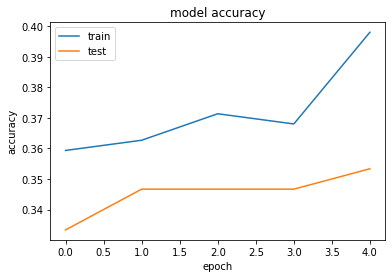

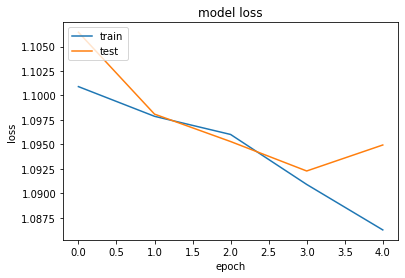

In [31]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=train_images.shape[1:]),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(len(class_names), activation='softmax')
])

#MeanSquaredError les résultats ne montent pas

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_images, train_labels, 
          validation_data=(validation_images, validation_labels), epochs=50)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Lib Rust

In [7]:
last_couche = 3
mlp = MLP(dll_path)
mlp.init_multicouche_model(np.array([IMG_HEIGHT * IMG_WIDTH * 3, 64, 64, 32, 8, last_couche], dtype='float64'))
mlp.activation_function = mlp.ActivationFunction.Tanh

mlp.train_multicouche_model_classification(train_images.flatten(), train_labels.flatten(), train_images.shape[0], 100.0, 0.2)
mlp.save_model("../App/interfacev2/Models/mlp.txt")

good_predict, number_of_predict = test(mlp, validation_images, validation_labels, last_couche)
print("Test :")
print(good_predict)
print(number_of_predict)

Test :
[0, 0, 50, 0]
[0, 50, 50, 50]
